# National Inventory of Dams

In [1]:
import matplotlib.pyplot as plt

import pygeohydro as gh

First, we need to instantiate the NID class.

In [2]:
nid = gh.NID()

Some dam coordinates are either missing or incorrect. Let's get dams that are within Contiguous US with max storage larger than 200 acre-feet. Note that since we want to get all dams within CONUS it's much more efficient set `stage_nid=True` in `NID.inventory_byid`. This flag downloads the latest version of the entire NID dataset and saves it as a feather file and query the inventory locally instead of NID web service.

In [3]:
conus_geom = gh.get_us_states("conus")

min_storage = 2500
dam_list = nid.get_byfilter([{"maxStorage": [f"[{min_storage} +inf]"]}])
dams = nid.inventory_byid(dam_list[0].federalId.to_list(), stage_nid=True)

conus_dams = dams[dams.stateKey.isin(conus_geom.STUSPS)].reset_index(drop=True)

Next, we can get a count of the top 10 dams based on types.

In [4]:
dam_purpose = conus_dams.primaryPurposeId.astype("Int8")
conus_dams["primaryPurposeIdName"] = dam_purpose.apply(nid.dam_purpose.get)

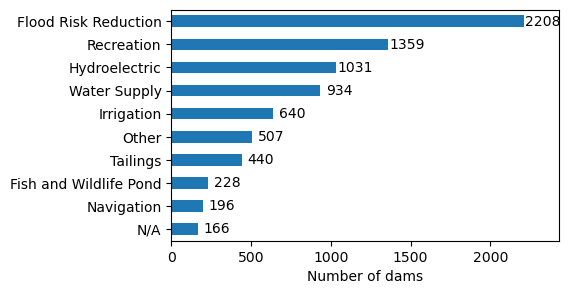

In [5]:
purpose_count = conus_dams["primaryPurposeIdName"].value_counts()
_, ax = plt.subplots(figsize=(5, 3), dpi=100)
purpose_count.sort_values()[-10:].plot.barh(ax=ax)
ax.set_xlim(0, purpose_count.max() * 1.1)
ax.set_xlabel("Number of dams")
for p in ax.patches:
    ax.annotate(
        int(p.get_width()),
        (p.get_width() + 120, p.get_y() + p.get_height() / 2),
        ha="center",
        va="center",
    )

Let's compare the spatial distribution of the top five categories, excluding Earth and Other categories.

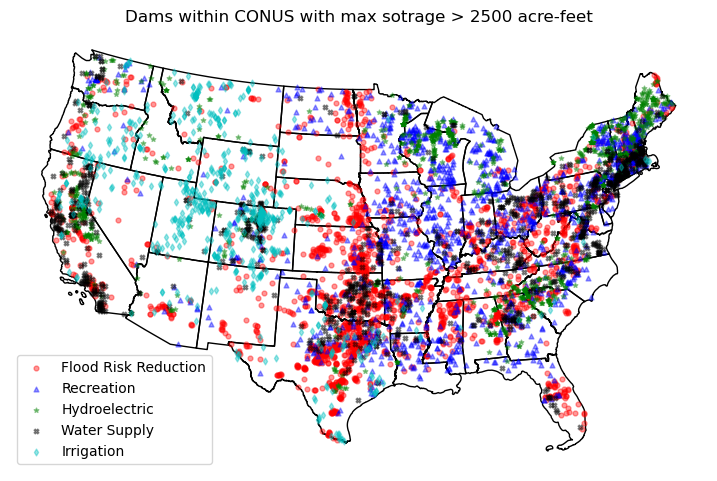

In [6]:
conus_geom = conus_geom.to_crs(5070)
conus_dams = conus_dams.to_crs(5070)

fig, ax = plt.subplots(figsize=(9, 6), dpi=100)
ax.set_title(f"Dams within CONUS with max sotrage > {min_storage} acre-feet")
conus_geom.plot(ax=ax, facecolor="none", edgecolor="k")
top_5types = purpose_count.index[:5]
marker = dict(zip(top_5types, ["o", "^", "*", "X", "d"]))
color = dict(zip(top_5types, ["r", "b", "g", "k", "c"]))

for c in top_5types:
    conus_dams[conus_dams.primaryPurposeIdName == c].plot(
        ax=ax,
        alpha=0.4,
        markersize=12,
        marker=marker[c],
        color=color[c],
        label=c,
    )
ax.legend(loc="best", ncols=1)
ax.axis(False)
fig.savefig("_static/dams.png")